The objective of this notebook is the same as the "learning_from_intervals" one with the use of neural networks

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator

from typing import Tuple

# Load dataset

In [2]:
def load_planar_dataset(n_example: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create and return a mock dataset. If we plot the data, we can see
    a sort of flower. The created dataset contains n_example X of 2 features
    and their associated label

    Args:
        n_example (int): number of examples in the wanted dataset

    Returns:
        Tuple[np.ndarray, np.ndarray]: Features matrix and associated labels vector
    """
    np.random.seed(1)
    n_representation = int(n_example/2)
    n_features = 2
    features = np.zeros((n_example, n_features))
    labels = np.zeros((n_example,1), dtype='uint8')
    max_ray = 4
    for label in range(2):
        index = range(n_representation*label,n_representation*(label+1))
        theta = np.linspace(
            label*3.12,(label+1)*3.12,n_representation
        ) + np.random.randn(n_representation)*0.2
        radius = max_ray*np.sin(4*theta) + np.random.randn(n_representation)*0.2
        features[index] = np.c_[radius*np.sin(theta), radius*np.cos(theta)]
        labels[index] = label
    return features, labels

In [3]:
def create_label_for_kld(label):
    if label == 0:
        number = np.round(np.random.uniform(0.5, 1), decimals=1)
    else:
        number = np.round(np.random.uniform(0, 0.49), decimals=1)
    return [number, 1-number]

In [4]:
X, Y = load_planar_dataset(n_example=4000)
df = pd.DataFrame(X, columns=["X1", "X2"])
df["Y"] = Y
df["Y_bis"] = df["Y"].apply(create_label_for_kld)
df.head()

,X1,X2,Y,Y_bis
0,1.261282,3.744878,0,"[0.7, 0.30000000000000004]"
1,0.218168,-1.797375,0,"[0.7, 0.30000000000000004]"
2,0.172355,-1.675405,0,"[0.7, 0.30000000000000004]"
3,0.645912,-3.031743,0,"[0.8, 0.19999999999999996]"
4,0.396580,2.187762,0,"[0.6, 0.4]"


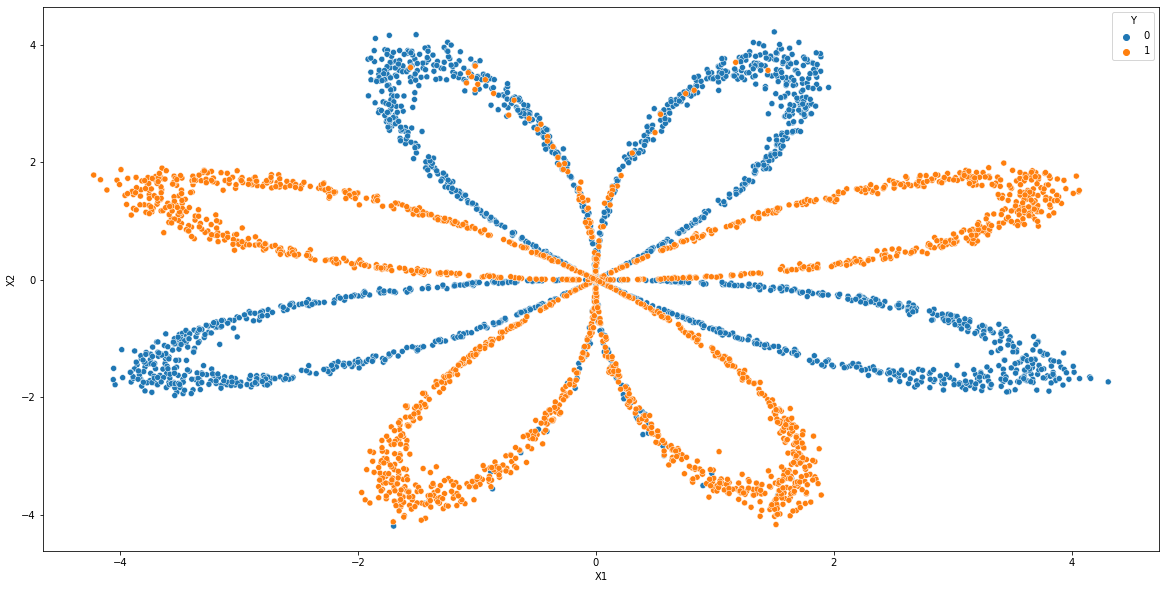

In [5]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="Y")
plt.show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df[["X1", "X2"]], df["Y"], train_size=0.8)

In [53]:
def get_classical_model():
    tf.random.set_seed(1)
    inputs = keras.Input(shape=(2, ), name="Input_layer")
    dense = layers.Dense(units=4, activation="relu", name="First_layer_connected_with_input")(inputs)
    dense2 = layers.Dense(units=4, activation="relu", name="Second_layer_connected_with_first_layer")(dense)
    outputs = layers.Dense(units=1, activation="sigmoid", name="Outputs_connected_with_second_layer")(dense2)
    model = keras.Model(inputs=inputs, outputs=outputs, name="first_test")
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return model

In [54]:
m1 = get_classical_model()
m1.fit(df[["X1", "X2"]], df["Y"], epochs=20)
df["predictions"] = m1.predict(df[["X1", "X2"]])
#df["predictions"] = df["predictions"].apply(lambda x: 1 if x >=0.5 else 0)

Epoch 1/20
125/125 [==============================] - 0s 1ms/step - loss: 0.7055 - accuracy: 0.4697
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6821 - accuracy: 0.5655
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6701 - accuracy: 0.5447
Epoch 4/20
125/125 [==============================] - 0s 999us/step - loss: 0.6616 - accuracy: 0.5378
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6514 - accuracy: 0.5285
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6400 - accuracy: 0.5350
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6309 - accuracy: 0.5443
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6225 - accuracy: 0.5510
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6143 - accuracy: 0.5555
Epoch 10/20
125/125 [==============================] - 0s 1ms/step - loss: 0.6062 - accuracy: 0.56

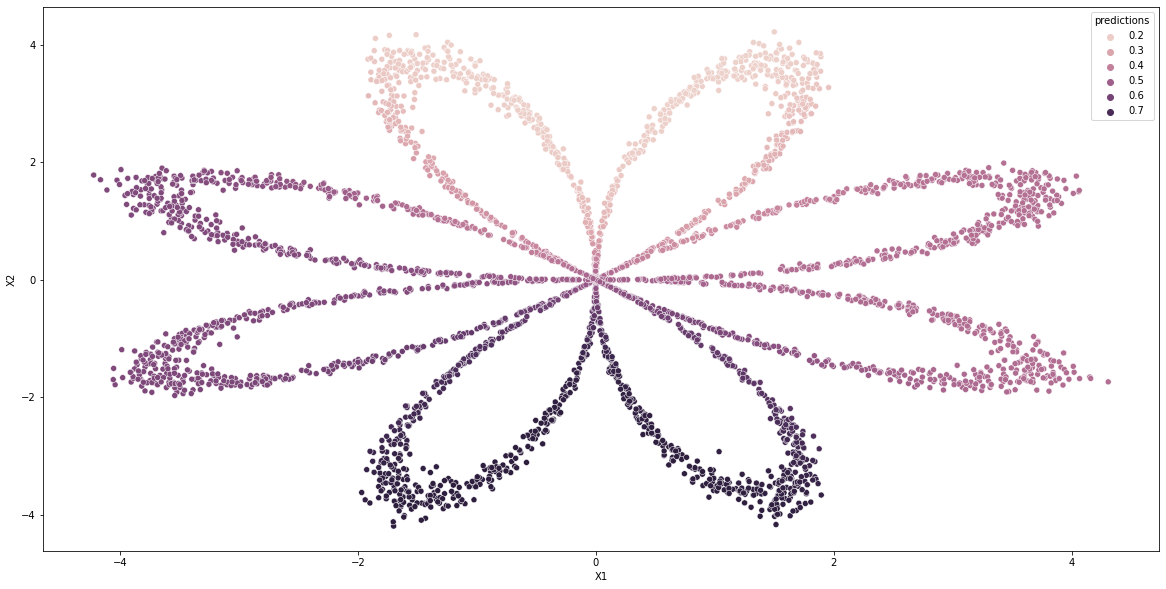

In [21]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="predictions")
plt.show()

In [55]:
def get_model_with_kl_divergence():
    tf.random.set_seed(1)
    inputs = keras.Input(shape=(2, ), name="Input_layer")
    dense = layers.Dense(units=4, activation="relu", name="First_layer_connected_with_input")(inputs)
    dense2 = layers.Dense(units=4, activation="relu", name="Second_layer_connected_with_first_layer")(dense)
    outputs = layers.Dense(units=1, activation="sigmoid", name="Outputs_connected_with_second_layer")(dense2)
    model = keras.Model(inputs=inputs, outputs=outputs, name="first_test")
    model.compile(optimizer="sgd", loss=tf.keras.losses.kullback_leibler_divergence, metrics=["accuracy"])
    return model

In [74]:
m2 = get_model_with_kl_divergence()
m2.fit(df[["X1", "X2"]], df["Y"], epochs=20)
df["predictions2"] = m2.predict(df[["X1", "X2"]])
df.head()

Epoch 1/20
125/125 [==============================] - 1s 1ms/step - loss: 0.2640 - accuracy: 0.4855
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1568 - accuracy: 0.5000
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.0988 - accuracy: 0.5000
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.0659 - accuracy: 0.5000
Epoch 5/20
125/125 [==============================] - 0s 984us/step - loss: 0.0467 - accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 0s 987us/step - loss: 0.0349 - accuracy: 0.5000
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.0272 - accuracy: 0.5000
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 0.5000
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.5000
Epoch 10/20
125/125 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.

,X1,X2,Y,Y_bis,predictions,predictions2
0,1.261282,3.744878,0,"[0.7, 0.30000000000000004]",0.019838,0.999377
1,0.218168,-1.797375,0,"[0.7, 0.30000000000000004]",0.826475,0.987286
2,0.172355,-1.675405,0,"[0.7, 0.30000000000000004]",0.817253,0.986117
3,0.645912,-3.031743,0,"[0.8, 0.19999999999999996]",0.863764,0.994800
4,0.396580,2.187762,0,"[0.6, 0.4]",0.139600,0.993508


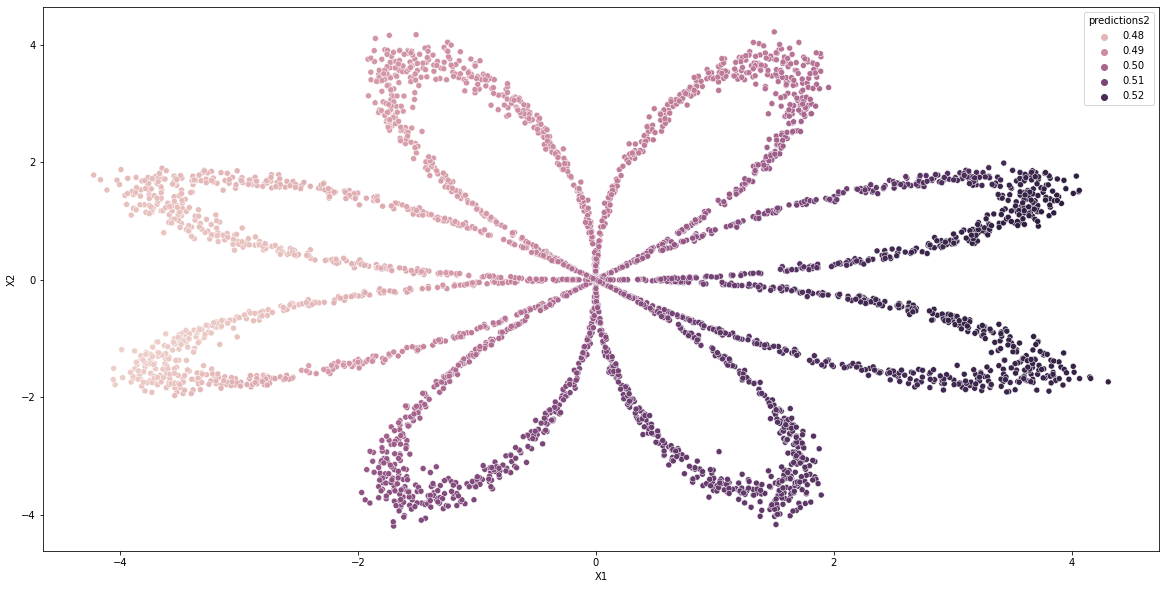

In [27]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="predictions2")
plt.show()

In [58]:
for layer in m1.layers:
    print(layer.name, layer)

Input_layer <keras.engine.input_layer.InputLayer object at 0x12e3be5b0>
First_layer_connected_with_input <keras.layers.core.dense.Dense object at 0x12e753700>
Second_layer_connected_with_first_layer <keras.layers.core.dense.Dense object at 0x12e7534c0>
Outputs_connected_with_second_layer <keras.layers.core.dense.Dense object at 0x12e51ea60>


In [59]:
for layer in m2.layers:
    print(layer.name, layer)

Input_layer <keras.engine.input_layer.InputLayer object at 0x12e891d60>
First_layer_connected_with_input <keras.layers.core.dense.Dense object at 0x12e87d430>
Second_layer_connected_with_first_layer <keras.layers.core.dense.Dense object at 0x12e897e20>
Outputs_connected_with_second_layer <keras.layers.core.dense.Dense object at 0x12e757910>


In [60]:
for layer in m1.layers:
    print(layer.weights)
    print()
    print()

[]


[<tf.Variable 'First_layer_connected_with_input/kernel:0' shape=(2, 4) dtype=float32, numpy=
array([[-0.6315011 ,  1.0128622 ,  0.5087806 , -0.4792729 ],
       [-0.61917347, -0.8460386 ,  1.2273939 , -0.6117235 ]],
      dtype=float32)>, <tf.Variable 'First_layer_connected_with_input/bias:0' shape=(4,) dtype=float32, numpy=array([-0.94816184,  0.6401293 , -0.62396157,  0.28821704], dtype=float32)>]


[<tf.Variable 'Second_layer_connected_with_first_layer/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[-0.19585858,  0.5714757 , -0.15842533,  1.1124884 ],
       [ 0.21717834, -1.2680312 , -0.11073524,  0.3422556 ],
       [ 0.5567795 ,  1.0691528 , -0.5404047 , -0.11757647],
       [ 0.64012146,  0.3905008 , -0.38123354, -1.0760298 ]],
      dtype=float32)>, <tf.Variable 'Second_layer_connected_with_first_layer/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.20508787, -0.16088367,  0.        ,  0.37936896], dtype=float32)>]


[<tf.Variable 'Outputs_connected_with_second_laye

In [61]:
for layer in m2.layers:
    print(layer.weights)
    print()
    print()

[]


[<tf.Variable 'First_layer_connected_with_input/kernel:0' shape=(2, 4) dtype=float32, numpy=
array([[-0.65443313,  0.83858407,  0.26024616, -0.16582468],
       [-0.40553993,  0.271177  ,  0.9619543 , -0.16864306]],
      dtype=float32)>, <tf.Variable 'First_layer_connected_with_input/bias:0' shape=(4,) dtype=float32, numpy=array([-0.01143949,  0.02268046,  0.00781025,  0.0360727 ], dtype=float32)>]


[<tf.Variable 'Second_layer_connected_with_first_layer/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.16662301, -0.08539505, -0.15842533,  0.82087713],
       [ 0.42128706, -0.2417142 , -0.11073524,  0.15547593],
       [ 0.00814484,  0.4680046 , -0.5404047 ,  0.06604827],
       [ 0.13113572,  0.08820633, -0.38123354, -0.6866853 ]],
      dtype=float32)>, <tf.Variable 'Second_layer_connected_with_first_layer/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.1898791 ,  0.02931049,  0.        , -0.0378366 ], dtype=float32)>]


[<tf.Variable 'Outputs_connected_with_second_laye

In [62]:
tf.keras.losses.kullback_leibler_divergence(y_true=df["Y"], y_pred=df["predictions2"])

<tf.Tensor: shape=(), dtype=float32, numpy=792.93176>